In [1]:
### Imports for pytorch

import torch
from torch.autograd import Variable
from groupy.gconv.pytorch_gconv import P4MConvZ2, P4MConvP4M

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
### Convolutional construction. See github repo @ COGMAR/RotEqNet

# Construct G-Conv layers
C1 = P4MConvZ2(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)
C2 = P4MConvP4M(in_channels=4, out_channels=10, kernel_size=3, stride=1, padding=1)

# Test code for tensor dimensions
# Create 10 images with 1 channels and 32x32 pixels:
img = torch.rand([1, 1, 32, 32])
print(img.shape)
print(img)
x = Variable(img)

# fprop
y = C1(x)
y = C2(y)
print(y.data.shape)
# print(y)

torch.Size([1, 1, 32, 32])
tensor([[[[0.1466, 0.6246, 0.7210,  ..., 0.4821, 0.1681, 0.2409],
          [0.0338, 0.7328, 0.6163,  ..., 0.1803, 0.4636, 0.5048],
          [0.9987, 0.3306, 0.6862,  ..., 0.3082, 0.0898, 0.5219],
          ...,
          [0.2261, 0.8562, 0.1258,  ..., 0.9912, 0.3423, 0.2511],
          [0.2178, 0.2716, 0.8034,  ..., 0.3125, 0.9955, 0.5817],
          [0.1416, 0.1884, 0.0353,  ..., 0.9533, 0.3542, 0.5000]]]])
torch.Size([1, 10, 8, 32, 32])


In [3]:
### Convolution construction code for groupy

# import torch.nn as nn
# from torch.nn import Parameter
# import torch.nn.functional as F
# import math
# from torch.nn.modules.utils import _pair
# from groupy.gconv.make_gconv_indices import *

# make_indices_functions = {(1, 4): make_c4_z2_indices,
#                           (4, 4): make_c4_p4_indices,
#                           (1, 8): make_d4_z2_indices,
#                           (8, 8): make_d4_p4m_indices}


# def trans_filter(w, inds):
#     inds_reshape = inds.reshape((-1, inds.shape[-1])).astype(np.int64)
#     w_indexed = w[:, :, inds_reshape[:, 0].tolist(), inds_reshape[:, 1].tolist(), inds_reshape[:, 2].tolist()]
#     w_indexed = w_indexed.view(w_indexed.size()[0], w_indexed.size()[1],
#                                     inds.shape[0], inds.shape[1], inds.shape[2], inds.shape[3])
#     w_transformed = w_indexed.permute(0, 2, 1, 3, 4, 5)
#     return w_transformed.contiguous()


# class SplitGConv2D(nn.Module):

#     def __init__(self, in_channels, out_channels, kernel_size, stride=1,
#                  padding=0, bias=True, input_stabilizer_size=1, output_stabilizer_size=4):
#         super(SplitGConv2D, self).__init__()
#         assert (input_stabilizer_size, output_stabilizer_size) in make_indices_functions.keys()
#         self.ksize = kernel_size

#         kernel_size = _pair(kernel_size)
#         stride = _pair(stride)
#         padding = _pair(padding)

#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.padding = padding
#         self.input_stabilizer_size = input_stabilizer_size
#         self.output_stabilizer_size = output_stabilizer_size

#         self.weight = Parameter(torch.Tensor(
#             out_channels, in_channels, self.input_stabilizer_size, *kernel_size))
#         if bias:
#             self.bias = Parameter(torch.Tensor(out_channels))
#         else:
#             self.register_parameter('bias', None)
#         self.reset_parameters()

#         self.inds = self.make_transformation_indices()

#     def reset_parameters(self):
#         n = self.in_channels
#         for k in self.kernel_size:
#             n *= k
#         stdv = 1. / math.sqrt(n)
#         self.weight.data.uniform_(-stdv, stdv)
#         if self.bias is not None:
#             self.bias.data.uniform_(-stdv, stdv)

#     def make_transformation_indices(self):
#         return make_indices_functions[(self.input_stabilizer_size, self.output_stabilizer_size)](self.ksize)

#     def forward(self, input):
#         tw = trans_filter(self.weight, self.inds)
#         tw_shape = (self.out_channels * self.output_stabilizer_size,
#                     self.in_channels * self.input_stabilizer_size,
#                     self.ksize, self.ksize)
#         tw = tw.view(tw_shape)

#         input_shape = input.size()
#         input = input.view(input_shape[0], self.in_channels*self.input_stabilizer_size, input_shape[-2], input_shape[-1])

#         y = F.conv2d(input, weight=tw, bias=None, stride=self.stride,
#                         padding=self.padding)
#         batch_size, _, ny_out, nx_out = y.size()
#         y = y.view(batch_size, self.out_channels, self.output_stabilizer_size, ny_out, nx_out)

#         if self.bias is not None:
#             bias = self.bias.view(1, self.out_channels, 1, 1, 1)
#             y = y + bias

#         return y


# class P4ConvZ2(SplitGConv2D):

#     def __init__(self, *args, **kwargs):
#         super(P4ConvZ2, self).__init__(input_stabilizer_size=1, output_stabilizer_size=4, *args, **kwargs)


# class P4ConvP4(SplitGConv2D):

#     def __init__(self, *args, **kwargs):
#         super(P4ConvP4, self).__init__(input_stabilizer_size=4, output_stabilizer_size=4, *args, **kwargs)


# class P4MConvZ2(SplitGConv2D):

#     def __init__(self, *args, **kwargs):
#         super(P4MConvZ2, self).__init__(input_stabilizer_size=1, output_stabilizer_size=8, *args, **kwargs)


# class P4MConvP4M(SplitGConv2D):

#     def __init__(self, *args, **kwargs):
#         super(P4MConvP4M, self).__init__(input_stabilizer_size=8, output_stabilizer_size=8, *args, **kwargs) 

In [4]:
### Download MNIST

# temp_dataset = torchvision.datasets.MNIST(
#     root = 'data',
#     download=True,
#     train=True,
#     transform=torchvision.transforms.Compose(
#         [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
#     ),
# )

In [5]:
### Test plotting of MNIST

# figure = plt.figure(figsize=(8, 8))
# sample_idx = torch.randint(len(dataset), size=(1,)).item()
# img, label = dataset[sample_idx]
# plt.title(label)
# plt.axis("off")
# plt.imshow(img.squeeze(), cmap="gray")
# plt.show()

In [6]:
### pytorch dataloader/dataset (RotMNIST)

from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.mnist import MNIST
import warnings
from PIL import Image
import os
import os.path
import numpy as np
import torch
import codecs
import string
from typing import Any, Callable, Dict, List, Optional, Tuple
from urllib.error import URLError
from torchvision.datasets.utils import download_and_extract_archive, extract_archive, verify_str_arg, check_integrity
import shutil
import torchvision.datasets.mnist as mts

import random

In [7]:
# ### RotMNIST dataset derived from VisionDataset 
# # (Probably could derive it from MNIST instead of just VisionDataset)

# class RotMNIST(VisionDataset):
#     """`RotMNIST`_ Dataset.

#     Args:
#         root (string): Root directory of dataset where ``RotMNIST/processed/training.pt``
#             and  ``RotMNIST/processed/test.pt`` exist.
#         train (bool, optional): If True, creates dataset from ``training.pt``,
#             otherwise from ``test.pt``.
#         download (bool, optional): If true, downloads the dataset from the internet and
#             puts it in root directory. If dataset is already downloaded, it is not
#             downloaded again.
#         transform (callable, optional): A function/transform that  takes in an PIL image
#             and returns a transformed version. E.g, ``transforms.RandomCrop``
#         target_transform (callable, optional): A function/transform that takes in the
#             target and transforms it.
#     """

#     mirrors = [
#         'http://yann.lecun.com/exdb/mnist/',
#         'https://ossci-datasets.s3.amazonaws.com/mnist/',
#     ]

#     resources = [
#         ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
#         ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
#         ("t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
#         ("t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c")
#     ]

#     training_file = 'training.pt'
#     test_file = 'test.pt'
#     classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
#                '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

#     @property
#     def train_labels(self):
#         warnings.warn("train_labels has been renamed targets")
#         return self.targets

#     @property
#     def test_labels(self):
#         warnings.warn("test_labels has been renamed targets")
#         return self.targets

#     @property
#     def train_data(self):
#         warnings.warn("train_data has been renamed data")
#         return self.data

#     @property
#     def test_data(self):
#         warnings.warn("test_data has been renamed data")
#         return self.data

#     def __init__(
#             self,
#             root: str,
#             train: bool = True,
#             transform: Optional[Callable] = None,
#             target_transform: Optional[Callable] = None,
#             download: bool = False,
#     ) -> None:
#         super(RotMNIST, self).__init__(root, transform=transform,
#                                     target_transform=target_transform)
#         self.train = train  # training set or test set

#         if self._check_legacy_exist():
#             self.data, self.targets = self._load_legacy_data()
#             return

#         if download:
#             self.download()

#         if not self._check_exists():
#             raise RuntimeError('Dataset not found.' +
#                                ' You can use download=True to download it')

#         self.data, self.targets = self._load_data()

#     def _check_legacy_exist(self):
#         processed_folder_exists = os.path.exists(self.processed_folder)
#         if not processed_folder_exists:
#             return False

#         return all(
#             check_integrity(os.path.join(self.processed_folder, file)) for file in (self.training_file, self.test_file)
#         )

#     def _load_legacy_data(self):
#         # This is for BC only. We no longer cache the data in a custom binary, but simply read from the raw data
#         # directly.
#         data_file = self.training_file if self.train else self.test_file
#         return torch.load(os.path.join(self.processed_folder, data_file))

#     def _load_data(self):
#         image_file = f"{'train' if self.train else 't10k'}-images-idx3-ubyte"
#         data =  mts.read_image_file(os.path.join(self.raw_folder, image_file))

#         label_file = f"{'train' if self.train else 't10k'}-labels-idx1-ubyte"
#         targets = mts.read_label_file(os.path.join(self.raw_folder, label_file))

#         return data, targets

#     def __getitem__(self, index: int) -> Tuple[Any, Any]:
#         """
#         Args:
#             index (int): Index

#         Returns:
#             tuple: (image, target) where target is index of the target class.
#         """
#         img, target = self.data[index], int(self.targets[index])

#         # doing this so that it is consistent with all other datasets
#         # to return a PIL Image
#         img = Image.fromarray(img.numpy(), mode='L')

#         if self.transform is not None:
#             img = self.transform(img)

#         if self.target_transform is not None:
#             target = self.target_transform(target)

#         # A note on the group p4m (rotation, flip, translation) and info on the conv.
#         # There are 4 possible rotations that can be done to form the rotation
#         # group of a set of data
#         # There are 2 possible flips than can be done that form the mirror 
#         # group of a set of data
#         # 
#         # Flipping both in X and in Y is the same as a rotation 180 degrees, and is
#         # therefore unecessary. Here is the procedure for generated the desired data:
#         # *     We decide the mirroring axis for the image (Image can stay the same,
#         # flip horiz. or flip vertically)
#         # *     We decide number of 90 degree rotations to apply to image

#         # Preform random rotation and mirroring for img
#         # Preform flip
#         img = torch.flip(img, [random.randint(-1, 1)])

#         # Preform random rotation (90 increments)
#         img = torch.rot90(img, random.randint(-1, 2), [-1, 1])

#         return img, target

#     def __len__(self) -> int:
#         return len(self.data)

#     @property
#     def raw_folder(self) -> str:
#         return os.path.join(self.root, self.__class__.__name__, 'raw')

#     @property
#     def processed_folder(self) -> str:
#         return os.path.join(self.root, self.__class__.__name__, 'processed')

#     @property
#     def class_to_idx(self) -> Dict[str, int]:
#         return {_class: i for i, _class in enumerate(self.classes)}

#     def _check_exists(self) -> bool:
#         return all(
#             check_integrity(os.path.join(self.raw_folder, os.path.splitext(os.path.basename(url))[0]))
#             for url, _ in self.resources
#         )

#     def download(self) -> None:
#         """Download the MNIST data if it doesn't exist already."""

#         if self._check_exists():
#             return

#         os.makedirs(self.raw_folder, exist_ok=True)

#         # download files
#         for filename, md5 in self.resources:
#             for mirror in self.mirrors:
#                 url = "{}{}".format(mirror, filename)
#                 try:
#                     print("Downloading {}".format(url))
#                     download_and_extract_archive(
#                         url, download_root=self.raw_folder,
#                         filename=filename,
#                         md5=md5
#                     )
#                 except URLError as error:
#                     print(
#                         "Failed to download (trying next):\n{}".format(error)
#                     )
#                     continue
#                 finally:
#                     print()
#                 break
#             else:
#                 raise RuntimeError("Error downloading {}".format(filename))

#     def extra_repr(self) -> str:
#         return "Split: {}".format("Train" if self.train is True else "Test")


C:\Users\Jack\anaconda3\envs\reu-code\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


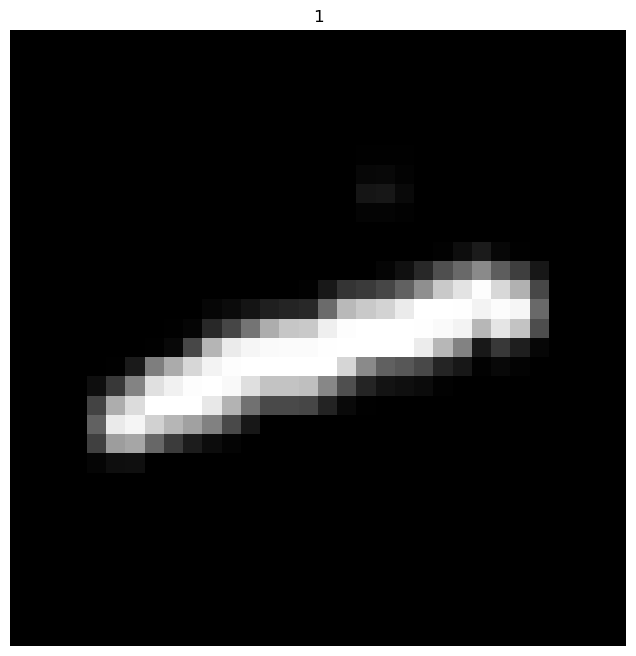

In [8]:
### Instatiate RotMNIST and verify behaviour
from RotMNIST import RotMNIST

rot_dataset = RotMNIST(
    root = 'data',
    download=True,
    train=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ),
)

test_rot_dataset = RotMNIST(
    root = 'data',
    download=True,
    train=False,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ),
)

# Show random index of dataset (See FashionMNIST ipynb for details)
figure = plt.figure(figsize=(8, 8))
sample_idx = torch.randint(len(rot_dataset), size=(1,)).item()
img, label = rot_dataset[sample_idx]
plt.title(label)
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Testing code for image manipulation
# flip_int = [random.randint(0, 1)]
# flip_int2 = [random.randint(-1, 0)]
# img = torch.flip(img, flip_int)
# img = torch.flip(img, flip_int2)
# print(flip_int)
# print(flip_int2)
# plt.title(label)
# plt.axis("off")
# plt.imshow(img.squeeze(), cmap="gray")
# plt.show()

Feature batch shape: torch.Size([64, 1, 32, 32])
Labels batch shape: torch.Size([64])


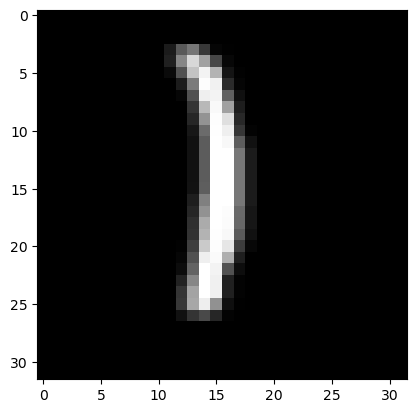

Label: 1


In [9]:
### Instantiate dataloader for RotMNIST and get batches

train_dataloader = DataLoader(rot_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_rot_dataset, batch_size=64, shuffle=True )
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img.shape
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# Define max pooling as from 

import torch.nn.functional as F

def plane_group_spatial_max_pooling(x, ksize, stride=None, pad=0):
    xs = x.size()
    x = x.view(xs[0], xs[1] * xs[2], xs[3], xs[4])
    x = F.max_pool2d(input=x, kernel_size=ksize, stride=stride, padding=pad)
    x = x.view(xs[0], xs[1], xs[2], x.size()[2], x.size()[3])
    return x

In [12]:
### Basic NN architecture to build off of for g-conv 
# NOTE: (use different pooling)

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__() 
        # self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv1 = P4MConvZ2(in_channels=1, out_channels=2, kernel_size=5, stride=1)
        # self.pool = nn.MaxPool2d(2, 2) - getting replaced by plane_group_max_pooling
        # self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2 = P4MConvP4M(in_channels=2, out_channels=4, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(4 * 8 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = plane_group_spatial_max_pooling(F.relu(self.conv1(x)), 2, stride=2)
        x = plane_group_spatial_max_pooling(F.relu(self.conv2(x)), 2, stride=2)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
    #     # 1 input image channel, 6 output channels, 5x5 square convolution
    #     # kernel
    #     self.conv1 = C1
    #     self.conv2 = C2
    #     # an affine operation: y = Wx + b
    #     self.fc1 = nn.Linear(20480, 32 * 32)  # 5*5 from image dimension
    #     self.fc2 = nn.Linear(32 * 32, 84)
    #     self.fc3 = nn.Linear(84, 10)

    # def forward(self, x):
    #     x = self.conv1(x)
    #     x = self.conv2(x)
    #     x = plane_group_spatial_max_pooling(x, 2)
    #     x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = self.fc3(x)
    #     return x

net = Net()
print(net)

params = list(net.parameters())
print(len(params))
print(params[0].size())

Net(
  (conv1): P4MConvZ2()
  (conv2): P4MConvP4M()
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
10
torch.Size([2, 1, 1, 5, 5])


In [13]:
learning_rate = 1e-4
batch_size = 64
epochs = 10

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        
        # Compute prediction and loss for backprop
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation by setting grad to zero, calculating using backprop engine and stepping (using learning rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    
    # No gradient on training data (faster computation and no optimization happening here anyway)
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y.to(device)).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

cuda:0


In [15]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable params: " + str(pytorch_total_params))

# 7464746
# 3733110
# 476604
# 1870524
# 374815
# 377494
# 709750 - Next: Max pool 2d has stride default to kernel
# 108790
# 88870

# Target: 61706
# Adjusted target: 76256
# Done



Number of trainable params: 88870


In [17]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, net, loss_fn, optimizer)
    test_loop(test_dataloader, net, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.762755  [    0/60000]
loss: 0.812133  [ 6400/60000]
loss: 1.118788  [12800/60000]
loss: 0.909206  [19200/60000]
loss: 0.503729  [25600/60000]
loss: 0.609040  [32000/60000]
loss: 0.551328  [38400/60000]
loss: 0.292702  [44800/60000]
loss: 0.624458  [51200/60000]
loss: 0.723482  [57600/60000]
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.008395 

Epoch 2
-------------------------------
loss: 0.545062  [    0/60000]
loss: 0.446862  [ 6400/60000]
loss: 0.521063  [12800/60000]
loss: 0.550398  [19200/60000]
loss: 0.391807  [25600/60000]
loss: 0.539759  [32000/60000]
loss: 0.298155  [38400/60000]
loss: 0.363351  [44800/60000]
loss: 0.850226  [51200/60000]
loss: 0.362298  [57600/60000]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.006793 

Epoch 3
-------------------------------
loss: 0.502451  [    0/60000]
loss: 0.412951  [ 6400/60000]
loss: 0.495356  [12800/60000]
loss: 0.211878  [19200/60000]
loss: 0.175255  [25600/60000]
loss: 0.566416  [32000/600